In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE

dataset_fname = "QSAR_dataset.xlsx"
test_fname = "test_TP1.xlsx"

# 1- Représentation des données
Dans cette étape, nous devons:
- analyser chaque attribut;
- proposer un prétraitement des données;
- sélectionner les 10 meilleurs attributs avec justification statistique;
- visualiser la distribution des 10 meilleurs attributs.

Commençon par charger les données.

### Chargement des données

In [ ]:
# Chargement des données d'entraînement
df = pd.read_excel(dataset_fname, index_col=0)
# Lecture rapide des cinq premières entrées pour valider le chargement adéquat des données
df.head(5)

## Analyser chaque attribut

Dans cette étape, nous analyserons chacun des attributs. Plus spécifiquement, nous devons déterminer les types (catégories, ordinales, cycliques, quantitatifs, etc.) des nos données. Ensuite, nous devons filtrer les valeurs aberrantes ou manquantes. Finalement, nous pouvons procéder à une analyse statistique primaire (moyenne, variance, équart-type, etc.).

#### Attributs quantitatifs et qualitatifs
D'abord, commençons par distinguer les attributs qualitatifs des attributs quantitatifs. Nous portons une attention particulière aux attributs qualitatifs (ou catégoriques) car ceux-ci nécessitent du pré-traitement particulier.

In [ ]:
df.info()

In [ ]:
num_cols = df.select_dtypes(exclude=["object", "category"]).columns.tolist()
cat_cols = df.select_dtypes(include=["category", "object"]).columns.tolist()
print("Nombre d'attributs numériques: {}".format(len(num_cols)))
print("Nombre d'attributs catégoriques: {}".format(len(cat_cols)))
if len(cat_cols) > 0:
    print(cat_cols)

Seul l'attribut `Class` est catégorique, ce qui est normal puisqu'il associe une classe à chacune des observations. Tous nos attributs sont donc numériques, ce qui facilitera grandement notre prétraitement.



#### Valeurs aberrantes
Maintenant, détectons les valeurs abberantes ou invalides (`NaN`, `±inf`, etc.). Dans notre traitement, nous commençons par convertir les valeurs `±inf` en `NaN` afin d'éviter des duplicata de code. En effet, ces valeurs nécessiteront le même pré-traitement alors une stratégie optimale consiste à les considérer de la même façon dès le départ.

In [ ]:
df = df.replace([-np.inf, np.inf], np.nan)
nan_cols = df.columns[df.isna().any()]
nan_summary = df[nan_cols].isna().sum().sort_values(ascending=False)
nan_ratio = nan_summary / len(df)
nan_df = pd.concat((nan_summary, nan_ratio), axis=1)
nan_df = nan_df.rename(columns={0: "Count", 1: "Ratio"})
print(nan_df)

On constate que les variables `vsurf_V` et `vsurf_S` contiennent beaucoup de valeurs manquates (11.69% et 8.44% respectivement). Par contraste, `ASA+`, `ASA-`, `a_heavy` et `a_IC` contiennent seulement entre 1 et 2 observations invalides. Plus tard, nous pourrons probablement les supprimer sans affecter grandement la distribution des données.

#### Valeurs uniques
Finalement, nous devons considérons les valeurs uniques. Celles-ci ne sont pas techniquement invalides, mais peuvent néamoins être ignorées car elles ne contribueront pas à la décision des algorithmes. En effet, puisque ces attributs prennent une seule valeur distincte, elles ne seront pas déterminantes dans la tâche de classification.

In [ ]:
uniq_cols = df.columns[df.nunique() == 1]
uniq_cols

La liste `uniq_cols` est vide, ce qui implique que tous les attributs possèdent plusieurs valeurs distinctes.

Supprimer les entrées dupliquées

In [ ]:
n_duplicated_rows = df.duplicated().sum()
df = df.drop_duplicates()
print("Lignes supprimées: {}".format(n_duplicated_rows))
print("Ratio: {:.4f}".format(n_duplicated_rows / len(df)))
assert df.duplicated().sum() == 0, "Erreur: il reste des doublons dans les données"

#### Analyse statistique
On peut maintenant extraire certaines statistiques de base pour tous les attributs

In [ ]:
df_describe = df.describe()
df_describe

Cette analyse primaire nous indique que les différentes variables respectent des échelles de grandeur très différentes. Par exemple, `apol` $\in [17, 53]$ tandis que `vsurf_R` $\in [-6.8\mathrm{e+}08, 1.61\mathrm{e-}01]$. Ce constat nous indique qu'un centrage et réduction par équart-type des différentes variables est nécessaire.

Avant de procéder, nous devons gérer les données manquates identifiées précedemment. Commençons par afficher toutes les lignes invalides.

In [ ]:
df[df.isna().any(axis=1)]

On constate que les valeurs invalides pour `ASA-`, `a_heavy` et `a_IC` se trouvent toutes sur des lignes distinctes. Si elles étaient toutes associées à la même ligne, nous aurions pu simplement supprimer cette ligne et perdre moins de 1% des données. Puisque notre jeu de données possèdent seulement $n=154$ observations, les stratégies d'ablation sont rejetées par défaut si elles retirent un trop grand pourcentage des données. Une stratégie alternative consiste à remplacer les valeurs manquantes par une valeur bien représentative. Ainsi, ré-affichons les statistiques élémentaires pour les colonnes invalides seulement.

In [ ]:
df[nan_cols].describe()

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12,8))

sns.kdeplot(df[["ASA+"]].to_numpy().reshape(-1), ax=axs[0, 0])
sns.kdeplot(df[["ASA-"]].to_numpy().reshape(-1), ax=axs[0, 1])
sns.kdeplot(df[["a_heavy"]].to_numpy().reshape(-1), ax=axs[0, 2])
sns.kdeplot(df[["a_IC"]].to_numpy().reshape(-1), ax=axs[1, 0])
sns.kdeplot(df[["vsurf_R"]].to_numpy().reshape(-1), ax=axs[1, 1])
sns.kdeplot(df[["vsurf_S"]].to_numpy().reshape(-1), ax=axs[1, 2])
sns.kdeplot(df[["vsurf_V"]].to_numpy().reshape(-1), ax=axs[2, 0])

plt.show()

Les diagrammes de densité nous indique que la distribution des variables `a_heavy`, `a_IC` et `vsurf_R` sont plutôt concentrées autour de leur moyenne respective. On peut donc remplacer les valeurs manquantes par la moyenne sans altérer la distribution ou introduire un biais ayant un impact significatif dans la tâche de classification. Pour les autres attributs, c'est-à-dire `ASA+`, `ASA-`, `vsurf_S` et `vsurf_V` , on utilise plutôt la valeur médiane. Mentionner approche intéressante: K-NN ou maximiser le likelihood considérant les autres attributs.

In [ ]:
# Remplacement des valeurs manquantes par la moyenne pour les attributs
# `a_heavy`, `a_IC` et `vsurf_R`.
for col in ["a_heavy", "a_IC", "vsurf_R"]:
    df.loc[:, col].fillna(df.loc[:, col].mean(), inplace=True)

# Remplacement des valeurs manquantes par la médiane pour les autres attributs restants
for col in set(nan_cols) - set(["a_heavy", "a_IC", "vsurf_R"]):
    df.loc[:, col].fillna(df.loc[:, col].median(), inplace=True)

# On valide la dernière opération en s'assurant qu'il ne reste aucun attribut avec des 
# valeurs manquates dans les données
n_remaining_nan = df.isna().sum().sum()
assert n_remaining_nan == 0, "Il reste {} valeurs manquantes".format(n_remaining_nan)

Débalancement de classe

In [ ]:
df["Class"].explode().value_counts()

Constate grand débalancement de classe. Suggère SMOTE pour équilibrer le tout.

In [ ]:
sm = SMOTE(
    random_state=42,
    sampling_strategy={"Class 1": 48, "Class -2": 48}
)
X, y = df.loc[:, df.columns != "Class"].to_numpy(), df.loc[:, "Class"].to_numpy() 
X_ovsld, y_ovsld = sm.fit_resample(X, y)
X = np.concatenate((np.expand_dims(y_ovsld, 1), X_ovsld), axis=1)
df = pd.DataFrame(X, columns=df.columns)
df.head(5)

Confirmation du rebalancement

In [ ]:
df["Class"].explode().value_counts()

Comme mentionné précédemment, les variables respectent des échelles de grandeur très différentes.
Il faut donc les centrer et les réduire.

In [ ]:
from sklearn.preprocessing import StandardScaler

# On copie le dataframe (sans les étiquettes) dans une matrice numpy X
X = df.loc[:, df.columns != "Class"].to_numpy(dtype=np.float32)
y = df.loc[:, "Class"]
# On applique un centrage et une réduction par équart-type de la matrice X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df_scaled = df.copy()
df_scaled[num_cols] = scaler.fit_transform(df[num_cols])

# On valide la dernière étape en s'assurant que les moyennes et écart-types 
# soient égaux à 0 et 1 respectivement
assert np.allclose(0., X_scaled.mean(axis=0), atol=1e-6), "Moyennes non centrées"
assert np.allclose(1., X_scaled.std(axis=0), atol=1e-6), "Écart-types différents de 1"

### Sélection des 10 meilleurs attributs
Nous présentons trois méthodes différentes pour sélectionner les attributs.
- les dix composantes principales (tirées de l'ACP) des variables non corrélées;
- les dix variables issues de la méthode `SelectKBest` de la librairie `SKLearn`.

In [ ]:
from sklearn.feature_selection import mutual_info_classif, SelectKBest

clf = SelectKBest(mutual_info_classif, k=10)
clf.fit(df_scaled[num_cols], y)
features_a = list(clf.get_feature_names_out())
features_a

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion="entropy", random_state=42, max_features=10)
clf.fit(X_scaled, y)
ind = np.argpartition(clf.feature_importances_, -10)[-10:]
features_b = list(df.columns[ind])
features_b

In [ ]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(verbose=False)
clf.fit(X_scaled, y)
ind = np.argpartition(clf.feature_importances_, -10)[-10:]
features_c = list(df.columns[ind])
features_c

In [ ]:
from xgboost import XGBClassifier

clf = XGBClassifier()
clf.fit(X_scaled, y)
ind = np.argpartition(clf.feature_importances_, -10)[-10:]
features_d = list(df.columns[ind])
features_d

In [ ]:
from collections import Counter

def default_value():
    return 0

all_features = features_a + features_b + features_c + features_d
features_dict = Counter(all_features)

features_df = pd.DataFrame(
    list(zip(features_dict.keys(), features_dict.values())),
    columns=["Attribut", "Décompte"]
).sort_values(ascending=False, by="Décompte")
features_df

In [ ]:
selected_features = features_df.loc[:, "Attribut"][0:10].tolist()
X = df_scaled.loc[:, selected_features].to_numpy(dtype=np.float32)
selected_features

b) Analyse de la corrélation

In [ ]:
# Code inspiré de https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Pour simplifier l'anal, on calcule la matrice de covariance absolue.
# Ainsi, les cases bleues indiquent une absence de corrélation et les cases rouges l'inverse.
corr_mat = df_scaled[selected_features].corr().abs()
# On masque le haut de la matrice diagonale
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
f, ax = plt.subplots(figsize=(12, 8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_mat, annot=False, cmap="BuPu")

In [ ]:
classes = list(set(df_scaled.loc[:, "Class"]))

f, axs = plt.subplots(3, 2, figsize=(12, 12))

f.tight_layout(pad=5)
for i, c in enumerate(classes):
    k = i // 2
    j = int(i % 2 != 0)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    corr_mat = df_scaled[(df_scaled.Class ==  c)].loc[:, selected_features].corr().abs()
    axs[k, j].set_title(c)
    sns.heatmap(corr_mat, annot=False, cmap="BuPu", ax=axs[k, j])


Données présentent corrélation très différentes en fonction des classes.
vsurf_R demeure l'attribut le plus consistant avec le moins de corrélation cumulative entre les classes. Seule la classe 2 présente une corrélation non négligeable pour cet attribut. Peut-être pertinent de procéder à ACP car données présentent forte corélation.

Nous procédons maintenant à une réduction de dimension par ACP. Au-lieu d'utiliser la librairie SKLearn, ...

In [ ]:
# Création de la matrice de corélation
Sigma = (1 / (len(df))) * (X.T @ X)
# Vérification que la diagonale de la matrice de corélation est contient des uns.
assert np.allclose(np.diag(Sigma), np.ones(Sigma.shape[0]), atol=1e-6)

# Décomposition valeurs, vecteurs propres
eig_vals, eig_vecs = np.linalg.eig(Sigma)
# Trier les vecteurs et valeurs propres de manière décroissante
# https://stackoverflow.com/questions/8092920/sort-eigenvalues-and-associated-eigenvectors-after-using-numpy-linalg-eig-in-pyt
idx = eig_vals.argsort()[::-1]   
eig_vals = eig_vals[idx]
eig_vecs = eig_vecs[:, idx]

# D'abord on calcule la somme de chaque valeur propre
sum_eigval = np.sum(eig_vals)
# Ensuite, on divise chacune des valeur propre par cette somme
var_prop = eig_vals / sum_eigval
cum_prop = np.cumsum(var_prop)
# Validation que la somme des proportions donne bien 1
assert(np.allclose(var_prop.sum(), 1))

# On crée une table pour présenter les résultats
d = {"Valeur propre": eig_vals, "Pourcentages": np.around(var_prop * 100, 4), "Pourcentages cumulés": np.around(cum_prop * 100, 4)}
eig_df = pd.DataFrame(data=d)
eig_df.head(10)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

x_labels = [i + 1 for i in range(len(var_prop))]

ax.plot(x_labels[0:15], var_prop[0:15], marker='o', markersize=6, color='blue', linewidth=2, label="Proportion de la variance")
ax.plot(x_labels[0:15], cum_prop[0:15], marker='o', color='orange', linewidth=2, label="Variance cumulée")
ax.legend()
ax.set_xticks(x_labels[0:15])
ax.set_title("Diagramme d'éboulis")
ax.set_xlabel("Composante principale")
ax.set_ylabel("Proportion de variance")
plt.show()

Le diagramme d'éboulis ainsi que le tableau des composantes principales nous informent que 86% de la variance est expliquée par seulement
les trois premières composantes principales. On projette donc nos données sur ces trois composantes. Différence de 10% entre la deuxième et la troisième composante. Par conséquent, projection 3CP favorisée quoique 2CP pourrait probablement s'avérer suffisant (76% variance cumulée). On évalue du même coup la qualité de la représentation à l'aide de deux métriques.
- $cos(\hat{X}, X) = \frac{||\hat{X}||^2}{||X||^2}$
- $d^2(\hat{X}, X) = ||\hat{X} - X||^2$

In [ ]:
M = 3
Pi = eig_vecs[:, 0:M]
Z = X @ Pi
X_hat = Z @ Pi.T
assert X_hat.shape == X.shape, "mauvais format de matrice"

d_cos = np.linalg.norm(X_hat)**2 / np.linalg.norm(X)**2
d_euc = np.linalg.norm(X_hat - X)
print("d_cos = {:.4f}\nd_euc = {:.4f}".format(d_cos, d_euc))

In [ ]:
eig_vals[eig_vals <= 0] = 0
L = eig_vecs * np.sqrt(eig_vals)
loading_df = pd.DataFrame(
    L[:, 0:M],
    index=selected_features,
    columns=["CP-{}".format(i + 1) for i in range(len(eig_vecs[0:M]))]
)
loading_df.to_csv("loading_df.csv")
loading_df.head(5)

In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

for i in range(M):
    axs[i, 0].set_ylabel("CP-{}".format(i+1))
    axs[M-1, i].set_xlabel("CP-{}".format(i+1))
    for j in range(M):
        axs[i, j].scatter(loading_df.iloc[:, i], loading_df.iloc[:, j])
        axs[i, j].set_yticks(np.arange(-1, 1.25, step=0.25))
        axs[i, j].set_xticks(np.arange(-1, 1.25, step=0.25))
        axs[i, j].set_xlim(-1, 1)
        axs[i, j].set_ylim(-1, 1)
        axs[i, j].grid()

        for k, txt in enumerate(selected_features):
            axs[i, j].annotate(txt, (loading_df.iloc[k, i], loading_df.iloc[k, j]))
        
plt.show()

In [ ]:
df_subset = df_scaled.loc[:, selected_features + ["Class"]]
sns.pairplot(df_subset.reset_index(), hue="Class", diag_kind=None)

In [ ]:
df_acp = pd.DataFrame(
    np.concatenate((Z, np.expand_dims(y, 1)), axis=1),
    columns=["CP-{}".format(i+1) for i in range(M)] + ["Class"],
)
df_acp.head(5)

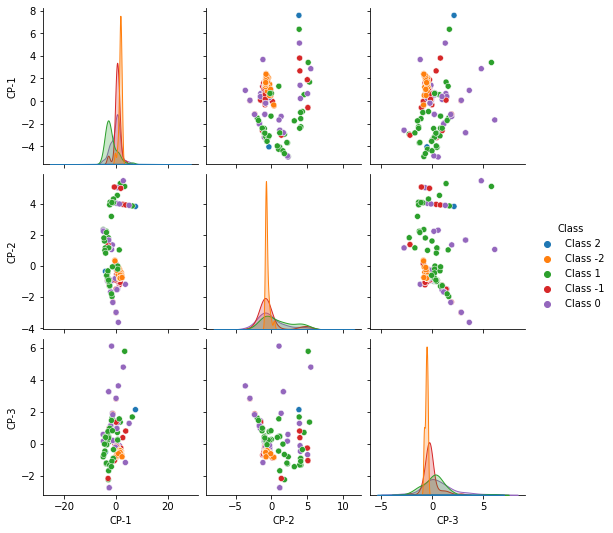

In [42]:
sns.pairplot(df_acp, hue="Class")

#### centroids


In [43]:
df_acp.groupby("Class").mean()

,CP-1,CP-2,CP-3
Class,,,
Class -1,0.457546,-0.287131,-0.173946
Class -2,1.606662,-0.628402,-0.611154
Class 0,-0.207221,-0.048556,0.621749
Class 1,-2.006912,0.939395,0.158936
Class 2,1.768020,1.741156,0.801748


In [ ]:
X = df_acp.loc[:, df_acp.columns != "Class"].to_numpy()


#### Analyse de la corélation
On commencer par filtrer les attributs présentant une forte corélation. Pour simplifier l'analyse, nous considérons seulement les valeurs absolues dans la matrice de corélation, car nous sommes intéressants par les forces de corélation et non leur direction.

In [ ]:
# Code inspiré de https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Pour simplifier l'anal, on calcule la matrice de covariance absolue.
# Ainsi, les cases bleues indiquent une absence de corrélation et les cases rouges l'inverse.
corr_mat = df_scaled[num_cols].corr().abs()
# On masque le haut de la matrice diagonale
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
f, ax = plt.subplots(figsize=(30, 20))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_mat, annot=False, cmap="BuPu")

In [ ]:
# Code inspiré de https://chrisalbon.com/code/machine_learning/feature_selection/drop_highly_correlated_features/
# Nous avons testé plusieurs ratio différents et celui-ci permettait de filtrer plusieurs attributs.
max_rho = 0.75
# Sélectionner triangle supérieur de la matrice de corrélation
upper = corr_mat.where(np.triu(np.ones_like(corr_mat), k=1).astype(bool))
# Sélectionner les attributs dont la corrélation dépasse le seuil `max_rho`
to_drop = [column for column in upper.columns if any(upper[column] >= max_rho)]
print("Total d'attributs dépassant le seuil {:.2f}: {}".format(max_rho, len(to_drop)))
print(to_drop)

# 2- Mesure de distance